Notebook by Zara

## **Faster R-CNN on small custom dataset**

Initial experiment

In [1]:
# import libraries 
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models  # Import models from TensorFlow

``Read data and folder path``

In [2]:
data = pd.read_excel('/Users/zaravanthoff/Desktop/data/annotations_cleaned.xlsx')

In [3]:
folder_path = "/Users/zaravanthoff/Desktop/data/images"

In [4]:
data

,Brand,Image,Xmin,Xmax,Ymin,Ymax,Class,ObjectWidth,ObjectHeight,Image Width,Image Height
0,ABN AMRO,1843248.JPG,1755,2385,4452,4649,0,630,197,3409,4900
1,ABN AMRO,1820597.JPG,1589,2212,4320,4590,0,623,270,3152,4708
2,ABN AMRO,1818130.JPG,2346,3038,2011,2189,0,692,178,3114,2230
3,ABN AMRO,18637600_01.JPG,2032,2423,2940,3042,0,391,102,2608,3232
4,ABN AMRO,1814797.JPG,2991,3102,392,506,0,111,114,3147,539
...,...,...,...,...,...,...,...,...,...,...,...
275,HEINEKEN,19338410_01.JPG,76,451,793,1008,7,375,215,3145,1093
276,HEINEKEN,19222870_01.JPG,1662,2197,664,962,7,535,298,2419,2951
277,HEINEKEN,1854656.JPG,2357,2808,1450,1711,7,451,261,3167,2174
278,HEINEKEN,19083970_01.JPG,2714,2949,922,1061,7,235,139,3175,1140


``Preprocess data (resize, normalize pixels)``

In [5]:
import cv2
import os
import pandas as pd
import numpy as np

def preprocess_data(data, folder_path, target_width=416, target_height=416):
    """
    Preprocesses images and labels from the given DataFrame.
    
    Args:
        data (DataFrame): DataFrame containing image filenames, labels, and bounding box coordinates.
        folder_path (str): Path to the folder containing the images.
        target_width (int): Target width for resizing the images.
        target_height (int): Target height for resizing the images.
    
    Returns:
        tuple: Tuple containing preprocessed images, labels, and adjusted bounding box coordinates.
    """
    resized_images = []
    labels = []
    adjusted_bboxes = []  # List to store adjusted bounding box coordinates

    # Iterate through each row in the dataset
    for index, row in data.iterrows():
        # Extract image filename from the dataset
        image_filename = row['Image']  # Accessing by column name
        
        # Construct the full path to the image
        image_path = os.path.join(folder_path, image_filename)
        
        try:
            # Read the image using OpenCV
            image = cv2.imread(image_path)
            
            # Check if the image was read successfully
            if image is None:
                raise FileNotFoundError(f"Unable to read image at path: {image_path}")
            
            # Resize the image to the target size
            resized_image = cv2.resize(image, (target_width, target_height))
            
            # Append resized image to the list
            resized_images.append(resized_image)
            
            # Append label to the list (assuming label is in the 'Class' column of the dataframe)
            label = row['Class']
            labels.append(label)
            
            # Adjust bounding box coordinates
            xmin = int(row['Xmin'] * (target_width / image.shape[1]))
            ymin = int(row['Ymin'] * (target_height / image.shape[0]))
            xmax = int(row['Xmax'] * (target_width / image.shape[1]))
            ymax = int(row['Ymax'] * (target_height / image.shape[0]))
            adjusted_bboxes.append((xmin, ymin, xmax, ymax))
            
            print(f"Image processed successfully: {image_filename}")
        except Exception as e:
            print(f"Error processing image at path {image_path}: {str(e)}")

    return np.array(resized_images), np.array(labels), np.array(adjusted_bboxes)

def compute_bbox_deltas(data, adjusted_bboxes):
    """
    Computes bounding box deltas based on adjusted bounding box coordinates and ground truth bounding box coordinates.

    Args:
        data (DataFrame): DataFrame containing ground truth bounding box coordinates.
        adjusted_bboxes (numpy array): Array containing adjusted bounding box coordinates.

    Returns:
        numpy array: Array containing bounding box deltas.
    """
    bbox_deltas = []
    for index, row in data.iterrows():
        xmin_true = row['Xmin']
        ymin_true = row['Ymin']
        xmax_true = row['Xmax']
        ymax_true = row['Ymax']

        xmin_adjusted, ymin_adjusted, xmax_adjusted, ymax_adjusted = adjusted_bboxes[index]

        dx = (xmin_true - xmin_adjusted) / (xmax_true - xmin_adjusted)
        dy = (ymin_true - ymin_adjusted) / (ymax_true - ymin_adjusted)
        dw = np.log((xmax_true - xmin_true) / (xmax_adjusted - xmin_adjusted))
        dh = np.log((ymax_true - ymin_true) / (ymax_adjusted - ymin_adjusted))

        bbox_deltas.append([dx, dy, dw, dh])

    return np.array(bbox_deltas)

In [6]:
# Preprocess images and labels
resized_images, labels, adjusted_bboxes = preprocess_data(data, folder_path)

Image processed successfully: 1843248.JPG
Image processed successfully: 1820597.JPG
Image processed successfully: 1818130.JPG
Image processed successfully: 18637600_01.JPG
Image processed successfully: 1814797.JPG
Image processed successfully: 1817506.JPG
Image processed successfully: 19404960_01.JPG
Image processed successfully: 18652740_01.JPG
Image processed successfully: 19457660_01.JPG
Image processed successfully: 1814903.JPG
Image processed successfully: 1844629.JPG
Image processed successfully: 1816345.JPG
Image processed successfully: 1818046.JPG
Image processed successfully: 18968450_01.JPG
Image processed successfully: 19284810_01.JPG
Image processed successfully: 1816316.JPG
Image processed successfully: 1825838.JPG
Image processed successfully: 1844443.JPG
Image processed successfully: 19466380_01.JPG
Image processed successfully: 19077290_01.JPG
Image processed successfully: 1814804.JPG
Image processed successfully: 1816911.JPG
Image processed successfully: 1805578.JPG
Im

In [7]:
# Normalize pixel values
resized_images = resized_images.astype('float32') / 255.0

# Check the range of pixel values after normalization
print("Minimum Pixel Value After Normalization:", np.min(resized_images))
print("Maximum Pixel Value After Normalization:", np.max(resized_images))

Minimum Pixel Value After Normalization: 0.0
Maximum Pixel Value After Normalization: 1.0


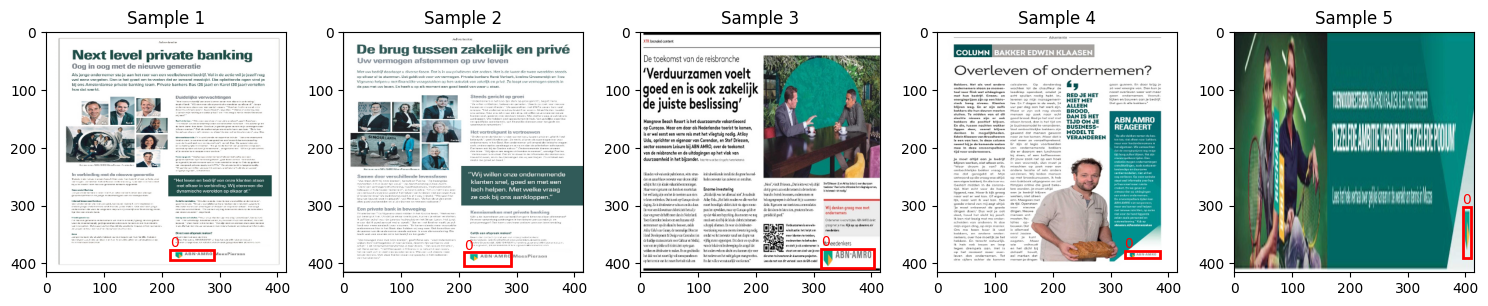

In [8]:
import matplotlib.pyplot as plt
import cv2
import os

def visualize_resized_samples(resized_images, adjusted_bboxes, labels, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i in range(num_samples):
        if i >= len(resized_images):
            break
        
        image = resized_images[i]
        bbox = adjusted_bboxes[i]
        label = labels[i]
        
        # Convert image to RGB format (OpenCV loads images in BGR format)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Plot the image
        axes[i].imshow(image_rgb)
        axes[i].set_title(f"Sample {i + 1}")
        
        # Plot bounding box
        xmin, ymin, xmax, ymax = bbox
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             edgecolor='r', facecolor='none', linewidth=2)
        axes[i].add_patch(rect)
        axes[i].text(xmin, ymin - 5, label, color='r')

    plt.tight_layout()
    plt.show()

# Visualize 5 samples from the preprocessed dataset
visualize_resized_samples(resized_images, adjusted_bboxes, labels, num_samples=5)

``Little more cleaning (inconsistencies in data and data types)``

In [9]:
print("Length of resized_images:", len(resized_images))
print("Length of labels:", len(labels))
print("Length of adjusted_bboxes:", len(adjusted_bboxes))

Length of resized_images: 280
Length of labels: 280
Length of adjusted_bboxes: 280


In [10]:
# Find indices of samples with complete bounding box data
valid_indices = [i for i in range(len(resized_images)) if i < len(adjusted_bboxes)]

# Filter out the valid samples
resized_images = [resized_images[i] for i in valid_indices]
labels = [labels[i] for i in valid_indices]
adjusted_bboxes = [adjusted_bboxes[i] for i in valid_indices]

# Now you have filtered datasets with consistent lengths

In [11]:
print("Type of resized_images:", type(resized_images))
print("Type of labels:", type(labels))
print("Type of adjusted_bboxes:", type(adjusted_bboxes))

Type of resized_images: <class 'list'>
Type of labels: <class 'list'>
Type of adjusted_bboxes: <class 'list'>


In [12]:
import numpy as np

# Convert lists to NumPy arrays
resized_images = np.array(resized_images)
labels = np.array(labels)
adjusted_bboxes = np.array(adjusted_bboxes)

# Check the types of the converted arrays
print("Type of resized_images_np:", type(resized_images))
print("Type of labels_np:", type(labels))
print("Type of adjusted_bboxes_np:", type(adjusted_bboxes))

Type of resized_images_np: <class 'numpy.ndarray'>
Type of labels_np: <class 'numpy.ndarray'>
Type of adjusted_bboxes_np: <class 'numpy.ndarray'>


``Split train/test/validation``

In [13]:
from sklearn.model_selection import train_test_split

# Assuming you have already preprocessed your data using the provided functions

# Split the data into training (80%) and temporary (20%) sets
train_data, temp_data, train_labels, temp_labels, train_bboxes, temp_bboxes = train_test_split(
    resized_images, labels, adjusted_bboxes, test_size=0.2, random_state=42)

# Split the temporary set into validation (50%) and test (50%) sets
val_data, test_data, val_labels, test_labels, val_bboxes, test_bboxes = train_test_split(
    temp_data, temp_labels, temp_bboxes, test_size=0.5, random_state=42)

# Check the sizes of the splits
print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Training data shape: (224, 416, 416, 3)
Validation data shape: (28, 416, 416, 3)
Test data shape: (28, 416, 416, 3)


In [15]:
import tensorflow as tf

# Assuming train_labels and val_labels are your class labels as integers
# Convert class labels to one-hot encoded vectors
num_classes = 8 # Number of classes in your dataset
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=num_classes)

# Verify the shape of the one-hot encoded labels
print("Shape of train_labels_one_hot:", train_labels.shape)
print("Shape of val_labels_one_hot:", val_labels.shape)

Shape of train_labels_one_hot: (224, 8)
Shape of val_labels_one_hot: (28, 8)


``Model architecture``

**Backbone: VGG-16**

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16

# Load pre-trained VGG-16 model without including the top (fully connected) layers
vgg_backbone = VGG16(weights='imagenet', include_top=False, input_shape=(416, 416, 3))

# Freeze the convolutional layers of the VGG-16 backbone
for layer in vgg_backbone.layers:
    layer.trainable = False

**Region Proposal Network (RPN)**

In [17]:
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Input

# Define the input tensor for the RPN
rpn_input = vgg_backbone.output  # Output of the VGG-16 backbone

# Add a 3x3 convolutional layer with 512 filters and 'same' padding
rpn_conv = Conv2D(512, (3, 3), padding='same', activation='relu', name='rpn_conv')(rpn_input)

# Add a 1x1 convolutional layer for predicting objectness scores
objectness_scores = Conv2D(2, (1, 1), activation='softmax', name='objectness_scores')(rpn_conv)

# Add a 1x1 convolutional layer for predicting bounding box deltas
bbox_deltas = Conv2D(4, (1, 1), activation='linear', name='bbox_deltas')(rpn_conv)

# Define the input and output tensors for the RPN
rpn_model = tf.keras.Model(inputs=vgg_backbone.input, outputs=[objectness_scores, bbox_deltas])

# Print the summary of the RPN model
# rpn_model.summary()

**Region of Interest Pooling (ROI)**

In [18]:
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, Concatenate
from tensorflow.keras.models import Model

# Define input tensor for ROI pooling
roi_input = rpn_model.output[0]  # Output of the RPN model

# Add a separate 2x2 MaxPooling2D layer for each output of the RPN model
pooling_layers = []
for output_tensor in rpn_model.output:
    pooling_layer = MaxPooling2D(pool_size=(2, 2))(output_tensor)
    pooling_layers.append(pooling_layer)

# Concatenate the pooled features along the channel axis
roi_pooling = Concatenate(axis=-1)(pooling_layers)

# Flatten the ROI pooled features
flattened_roi = Flatten()(roi_pooling)

# Add fully connected layers for classification and regression
fc1 = Dense(1024, activation='relu')(flattened_roi)
fc2 = Dense(1024, activation='relu')(fc1)

# Output layer for classification
num_classes = 8  # Example: 20 object classes + background (??)
classification_output = Dense(num_classes, activation='softmax', name='classification')(fc2)

# Output layer for bounding box regression
regression_output = Dense(4, activation='linear', name='regression')(fc2)

# Define input and output tensors for the ROI pooling model
roi_model = Model(inputs=rpn_model.input, outputs=[classification_output, regression_output])

# Print the summary of the ROI pooling model
# roi_model.summary()

**Bounding box regression and classification**

In [19]:
from tensorflow.keras.layers import Flatten, Dense

# Assuming rpn_model.output is a tuple containing multiple tensors
rpn_output_tensor = rpn_model.output[0]  # Choose the first tensor from the tuple

# Flatten the output of the RPN
rpn_output_flattened = Flatten()(rpn_output_tensor)

# Add fully connected layers for bounding box regression
bbox_regression_fc1 = Dense(512, activation='relu')(rpn_output_flattened)
bbox_regression_fc2 = Dense(512, activation='relu')(bbox_regression_fc1)
bbox_deltas_output = Dense(4, activation='linear', name='bbox_deltas')(bbox_regression_fc2)  # Output layer for bounding box regression

# Add fully connected layers for object classification
classification_fc1 = Dense(512, activation='relu')(rpn_output_flattened)
classification_fc2 = Dense(512, activation='relu')(classification_fc1)
num_classes = 8 # Example: 20 object classes + background
classification_output = Dense(num_classes, activation='softmax', name='classification')(classification_fc2)  # Output layer for classification

# Define input and output tensors for the model
final_model = tf.keras.Model(inputs=rpn_model.input, outputs=[classification_output, bbox_deltas_output])

# Print the summary of the final model
# final_model.summary()


**Loss function**

In [20]:
import tensorflow as tf

def rpn_classification_loss(y_true, y_pred):
    # y_true: true labels (1 for positive anchors, 0 for negative anchors, -1 for neutral anchors)
    # y_pred: predicted probabilities for objectness scores (softmax output)
    if tf.sparse.is_sparse(y_true):
        print("y_true is a SparseTensor")
    else:
        print("y_true is not a SparseTensor")
    
    # Filter out the neutral anchors (-1 labels)
    indices = tf.where(tf.not_equal(y_true, -1))
    y_true = tf.gather_nd(y_true, indices)
    y_pred = tf.gather_nd(y_pred, indices)
    
    # Compute binary cross-entropy loss
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    return tf.reduce_mean(loss)

def rpn_regression_loss(y_true, y_pred):
    # y_true: true bounding box deltas
    # y_pred: predicted bounding box deltas
    
    # Filter out the neutral anchors (-1 labels)
    indices = tf.where(tf.not_equal(tf.reduce_sum(tf.abs(y_true), axis=1), 0))
    y_true = tf.gather_nd(y_true, indices)
    y_pred = tf.gather_nd(y_pred, indices)
    
    # Compute smooth L1 loss
    loss = tf.keras.losses.Huber()(y_true, y_pred)
    
    return tf.reduce_mean(loss)

def rcnn_classification_loss(y_true, y_pred):
    # y_true: true class labels (one-hot encoded)
    # y_pred: predicted class probabilities
    
    # Compute categorical cross-entropy loss
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    
    return tf.reduce_mean(loss)

def rcnn_regression_loss(y_true, y_pred):
    # y_true: true bounding box deltas
    # y_pred: predicted bounding box deltas
    
    # Compute smooth L1 loss
    loss = tf.keras.losses.Huber()(y_true, y_pred)
    
    return tf.reduce_mean(loss)

# Combine the losses for RPN and RCNN
def total_loss(y_true, y_pred):
    rpn_cls_true, rpn_reg_true, rcnn_cls_true, rcnn_reg_true = y_true
    rpn_cls_pred, rpn_reg_pred, rcnn_cls_pred, rcnn_reg_pred = y_pred
    
    rpn_cls_loss = rpn_classification_loss(rpn_cls_true, rpn_cls_pred)
    rpn_reg_loss = rpn_regression_loss(rpn_reg_true, rpn_reg_pred)
    rcnn_cls_loss = rcnn_classification_loss(rcnn_cls_true, rcnn_cls_pred)
    rcnn_reg_loss = rcnn_regression_loss(rcnn_reg_true, rcnn_reg_pred)
    
    total_loss = rpn_cls_loss + rpn_reg_loss + rcnn_cls_loss + rcnn_reg_loss
    
    return total_loss

``Training``

In [21]:
# Compile the model with appropriate loss functions and metrics
final_model.compile(optimizer='adam',
                    loss={'classification': rcnn_classification_loss, 'bbox_deltas': rcnn_regression_loss},
                    loss_weights={'classification': 1.0, 'bbox_deltas': 1.0},
                    metrics={'classification': 'accuracy', 'bbox_deltas': 'mae'})

In [22]:
# Train the model
history = final_model.fit(train_data, [train_labels, train_bboxes],
                           batch_size=32,
                           epochs=20,
                           validation_data=(val_data, [val_labels, val_bboxes]))

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 107s 16s/step - bbox_deltas_mae: 290.9203 - classification_accuracy: 0.1318 - loss: 292.6911 - val_bbox_deltas_mae: 301.5835 - val_classification_accuracy: 0.2143 - val_loss: 303.2596
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 122s 18s/step - bbox_deltas_mae: 266.4276 - classification_accuracy: 0.0824 - loss: 268.1965 - val_bbox_deltas_mae: 259.3177 - val_classification_accuracy: 0.1429 - val_loss: 261.0317
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 121s 18s/step - bbox_deltas_mae: 218.8900 - classification_accuracy: 0.1265 - loss: 220.5350 - val_bbox_deltas_mae: 168.0325 - val_classification_accuracy: 0.1071 - val_loss: 169.6499
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 123s 18s/step - bbox_deltas_mae: 145.6249 - classification_accuracy: 0.1274 - loss: 147.2367 - val_bbox_deltas_mae: 75.8395 - val_classification_accuracy: 0.1786 - val_loss: 77.4397
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 126s 18s/step - bbox_deltas_mae: 103.9215 - classification_accuracy: 0.1068 - loss: 10

In [23]:
final_model.save("rcnn_model2.keras")

``Plotting learning curve``

Look for signs of overfitting (increased validation loss or decreasing validation accuracy) as training progresses.

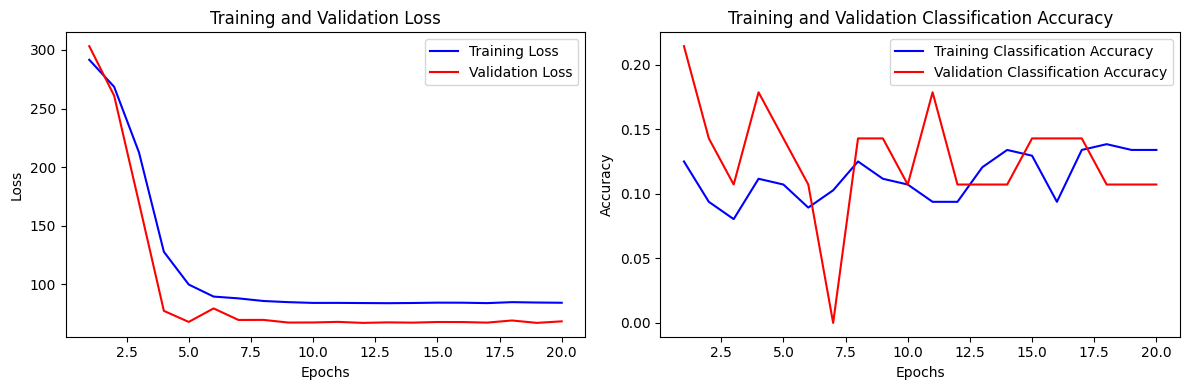

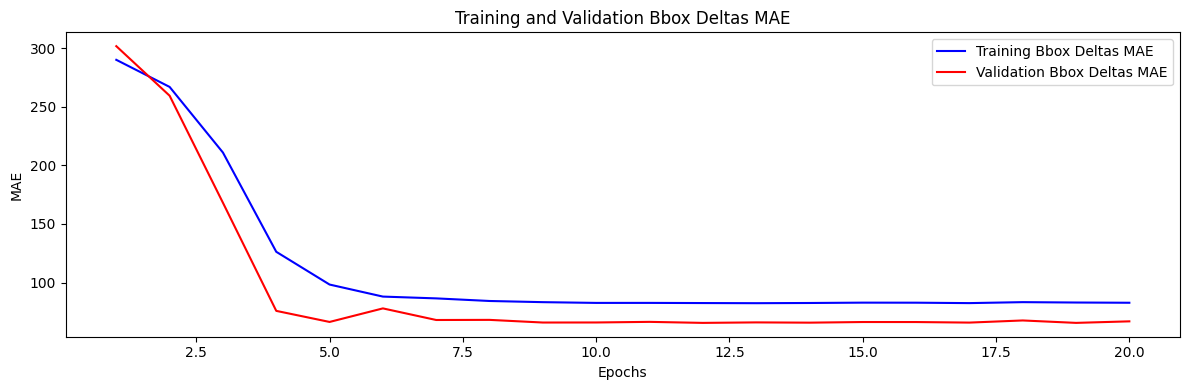

In [24]:
import matplotlib.pyplot as plt

# Extract available training and validation metrics from history object
loss = history.history['loss']
classification_accuracy = history.history['classification_accuracy']
bbox_deltas_mae = history.history['bbox_deltas_mae']
val_loss = history.history['val_loss']
val_classification_accuracy = history.history['val_classification_accuracy']
val_bbox_deltas_mae = history.history['val_bbox_deltas_mae']

epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation classification accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, classification_accuracy, 'b-', label='Training Classification Accuracy')
plt.plot(epochs, val_classification_accuracy, 'r-', label='Validation Classification Accuracy')
plt.title('Training and Validation Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot training and validation bounding box deltas MAE
plt.figure(figsize=(12, 4))
plt.plot(epochs, bbox_deltas_mae, 'b-', label='Training Bbox Deltas MAE')
plt.plot(epochs, val_bbox_deltas_mae, 'r-', label='Validation Bbox Deltas MAE')
plt.title('Training and Validation Bbox Deltas MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

``Testing and predicting``

**Testing**

In [25]:
# Make predictions on the test set
predictions = final_model.predict(test_data)

# Unpack the predictions
test_label_predictions, test_bbox_predictions = predictions

# Now 'test_label_predictions' contains the predicted labels
# and 'test_bbox_predictions' contains the predicted bounding boxes

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


**Show predictions**

In [27]:
import numpy as np
import pandas as pd

# Randomly select a few samples for inspection
num_samples_to_inspect = 5
random_indices = np.random.choice(len(test_data), num_samples_to_inspect, replace=False)

# Get unique class labels from your dataset
class_labels = data['Class'].unique().tolist()

# Iterate over the selected samples
for i, idx in enumerate(random_indices):
    print(f"Sample {i+1}:")
    
    # Decode predicted label
    predicted_class_index = np.argmax(test_label_predictions[idx])
    predicted_class = class_labels[predicted_class_index]
    
    # Print predicted label and true label
    print("Predicted Label:", predicted_class)
    print("True Label:", test_labels[idx])  # Assuming test_labels contains true label indices
    
    # Print predicted bounding box and true bounding box
    print("Predicted Bounding Box:", test_bbox_predictions[idx])
    print("True Bounding Box:", test_bboxes[idx])
    
    print("\n")

Sample 1:
Predicted Label: 5
True Label: 1
Predicted Bounding Box: [283.26395 345.0189  366.7989  383.5131 ]
True Bounding Box: [300 348 333 397]


Sample 2:
Predicted Label: 5
True Label: 4
Predicted Bounding Box: [283.26395 345.0189  366.7989  383.5131 ]
True Bounding Box: [246 320 318 331]


Sample 3:
Predicted Label: 5
True Label: 0
Predicted Bounding Box: [283.26395 345.01895 366.7989  383.5131 ]
True Bounding Box: [305  11 413  47]


Sample 4:
Predicted Label: 5
True Label: 4
Predicted Bounding Box: [283.26395 345.01895 366.7989  383.5131 ]
True Bounding Box: [259   7 409  40]


Sample 5:
Predicted Label: 5
True Label: 2
Predicted Bounding Box: [283.26395 345.01898 366.7989  383.51312]
True Bounding Box: [  6 386  57 408]




**Accuracy**

In [29]:
from sklearn.metrics import accuracy_score

# Assuming 'test_labels' are the true labels and 'predicted_labels' are the predicted labels
# Extract true labels and predicted labels
true_labels = test_labels  # Assuming 'test_labels' is the true label array
predicted_labels = [np.argmax(pred) for pred in test_label_predictions]  # Convert predicted probabilities to labels

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Final Accuracy:", accuracy)

Final Accuracy: 0.07142857142857142


**Intersection of Union**

In [34]:
def calculate_iou(true_bbox, pred_bbox):
    # Extract coordinates of true bounding box
    true_x1, true_y1, true_w1, true_h1 = true_bbox
    true_x2 = true_x1 + true_w1
    true_y2 = true_y1 + true_h1
    
    # Extract coordinates of predicted bounding box
    pred_x1, pred_y1, pred_w1, pred_h1 = pred_bbox
    pred_x2 = pred_x1 + pred_w1
    pred_y2 = pred_y1 + pred_h1
    
    # Calculate coordinates of intersection
    inter_x1 = max(true_x1, pred_x1)
    inter_y1 = max(true_y1, pred_y1)
    inter_x2 = min(true_x2, pred_x2)
    inter_y2 = min(true_y2, pred_y2)
    
    # Calculate area of intersection
    inter_area = max(0, inter_x2 - inter_x1 + 1) * max(0, inter_y2 - inter_y1 + 1)
    
    # Calculate area of true bounding box
    true_area = true_w1 * true_h1
    
    # Calculate area of predicted bounding box
    pred_area = pred_w1 * pred_h1
    
    # Calculate area of union
    union_area = true_area + pred_area - inter_area
    
    # Calculate IoU
    iou = inter_area / union_area
    
    return iou

# Example usage:
sample_index = 0  # Choose the index of the sample to calculate IoU

# Extract true and predicted bounding boxes for the chosen sample
true_bbox = test_bboxes[random_indices[sample_index]]
pred_bbox = test_bbox_predictions[random_indices[sample_index]]

# Calculate IoU for the sample
iou = calculate_iou(true_bbox, pred_bbox)
print("Intersection over Union (IoU):", iou)

Intersection over Union (IoU): 0.26640863979134877


**Visualisation**

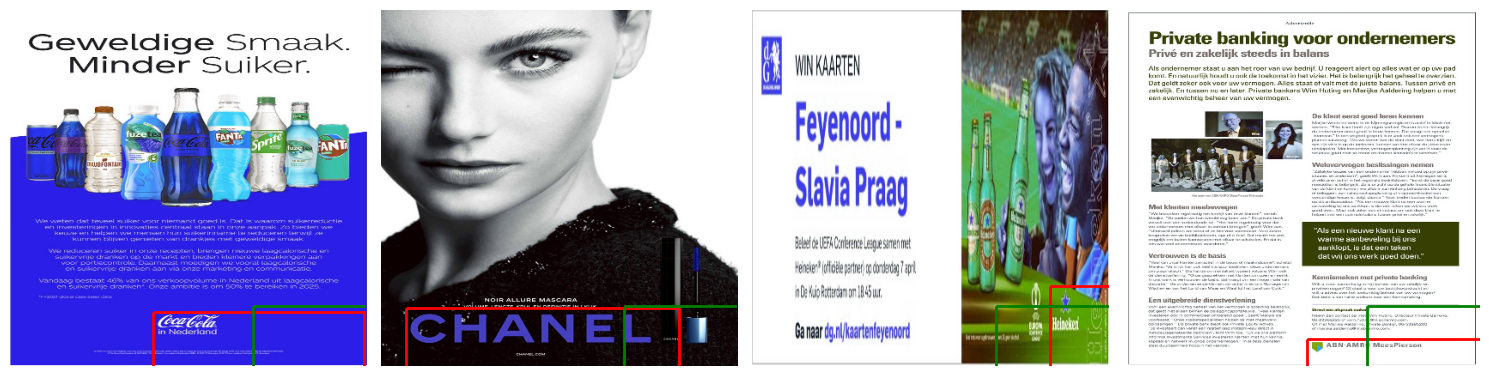

In [31]:
import matplotlib.pyplot as plt

# Function to plot images with bounding boxes
def plot_images_with_bboxes(images, true_bboxes, pred_bboxes):
    num_images = len(images)
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 5))

    for i, ax in enumerate(axes):
        # Plot image
        ax.imshow(images[i])
        ax.axis('off')

        # Plot true bounding box
        true_bbox = true_bboxes[i]
        ax.add_patch(plt.Rectangle((true_bbox[0], true_bbox[1]), true_bbox[2], true_bbox[3],
                                   edgecolor='r', facecolor='none', linewidth=2))

        # Plot predicted bounding box
        pred_bbox = pred_bboxes[i]
        ax.add_patch(plt.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3],
                                   edgecolor='g', facecolor='none', linewidth=2))

    plt.tight_layout()
    plt.show()

# Select a few random samples for visualization
num_samples_to_visualize = 4
random_indices = np.random.choice(len(test_data), num_samples_to_visualize, replace=False)

# Get the corresponding images, true bounding boxes, and predicted bounding boxes
visualize_images = [test_data[idx] for idx in random_indices]
true_bboxes_to_visualize = [test_bboxes[idx] for idx in random_indices]
pred_bboxes_to_visualize = [test_bbox_predictions[idx] for idx in random_indices]

# Plot the images with bounding boxes
plot_images_with_bboxes(visualize_images, true_bboxes_to_visualize, pred_bboxes_to_visualize)


# red = true, green = predicted

--------------------

**How does Faster R-CNN recognizes logos in print ads?**

It recognizes logos primarily based on their features extracted from the ``image pixels``. It doesn't directly recognize logos based on their size or location but rather learns to detect objects by analyzing the features present in different regions of the image. 

--> Overall, Faster R-CNN recognizes logos based on the features extracted from the image pixels (using a combination of region proposals, feature extraction, object classification/regression). 

The features extracted by the CNN are representations of the image regions that are useful for distinguihsing between different objects and backgrounds. This is what these features might represent:
- Low-level features: basic visual patterns such as edges, corners, and textures.
- Mid-level features: more complex visual patterns such as object parts, textures, and shapes. 
- High-level features: information about objects and scenes (global context and relationshipt between objects).

The features extracted by the CNN are hierarchical, meaning that higher-level feature are built upon lower-level features.
Example: a high-level feature representing the presence of a car might be built upon mid-level features representing wheels, windows, and a body shape, which in turn are built upon low-level features representing edges and textures. 

These learned features are crucial for detecting objects because they encode diverse information about the objects' appearance and structure. The region proposal network (RPN) and subsequent object classification and bounding box regression layers use these feature to make prediction about the presence, location, and class of objects in the image. 

---------------------------

**How is the accuracy being calculated?**

1. Classification accucary: 
- Whether the model correctly predicts the presence of an object in a region proposal and assigns the correst class label to it.
- Calculation: proportion of correctly classified objects (true positives) out of all objects in the dataset.

2. Localization accuracy: 
- How accurately the model localizes objects by predicting their bounding boxes. 
- Calculation: using the metrics Intersection over Union, the overlap between the predicted bounding boxes and the ground truth bounding boxes. ``Threshold for considering a prediction as correct is 50% (IoU = 0.5)``

3. Mean Average Precision (mAP) --> accuracy
- Combines both classification and localization accuracy: it computes the average precision (AP) for each class and then averages them over all classes. 
- It takes into account both the accuracy of object detection (whether an object is detected or not) and the accuracy of object lcoalization (how accurately the object is localized).

--> An accuracy of 0.85 means that the model correctly predcted 85% of the samples in the dataset
